#                  **Classificação de Jurisprudência do TCU**


**Descrição do Projeto:**

Classificar as Jurisprudências do TCU,a partir do texto da súmula. As classificações são em dez áreas, sendo elas: Competência do TCU, Contrato Administrativo, Convênio, Desestatização, Direito Processual, Finanças Públicas, Gestão Administrativa, Licitação, Pessoal e Responsabilidade. 

**Fonte de Dados**:

Portal do Tribunal de Contas da União, disponível em: <https://portal.tcu.gov.br/inicio/index.htm>.

### **Importar Bibliotecas**

In [2]:
import os
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1000
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import imblearn


import matplotlib as m
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from time import time
from joblib import dump, load

#import logging


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score 
from sklearn import metrics


import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Montar Drive**

In [3]:
# mostrar o diretório atual (current folder)
%pwd

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# mudar o diretório ou pasta (folder) para o local que contém os arquivos de dados
%cd /content/drive/MyDrive/Colab Notebooks/bootcamp/ProjetoTCU/dados

/content/drive/MyDrive/Colab Notebooks/bootcamp/ProjetoTCU/dados


### **Importar os dados e criar o DataFrame**





In [6]:
%ll

total 96065
-rw------- 1 root   360960 Dec  2 21:00  Competencia_do_TCU_657.xls
-rw------- 1 root   581632 Dec  2 21:01  Contrato_Administrativo_1026.xls
-rw------- 1 root   428544 Dec  2 21:03  Convenio_760.xls
-rw------- 1 root   104960 Dec  2 21:05  Desestatizacao_147.xls
-rw------- 1 root  1077760 Dec  2 21:18 'Direito Processual_2164.xls'
-rw------- 1 root   295424 Dec  2 21:19  Financas_Publicas_418.xls
-rw------- 1 root   231936 Dec  2 21:23  GestaoAdministrativa_371.xls
-rw------- 1 root  1640448 Dec  2 22:23  Licitacao_3002.xls
-rw------- 1 root   942301 Dec 14 19:10  modelo_tf-idf_sklearn_tcu_jurisprudencia1.pkl
-rw------- 1 root   866293 Dec 14 19:10  modelo_tf-idf_sklearn_tcu_jurisprudencia2.pkl
-rw------- 1 root 84534248 Dec 14 19:10  modelo_tf-idf_sklearn_tcu_jurisprudencia3.pkl
-rw------- 1 root  3785997 Dec  7 05:21  modelo_tf-idf_sklearn_tcu_jurisprudencia.pkl
-rw------- 1 root  2129408 Dec  2 22:24  Pessoal_3989.xls
-rw------- 1 root  1390080 Dec  2 22:24  Responsabil

In [7]:
path = os.getcwd()
files = os.listdir(path)
files_xls = [f for f in files if f[-3:] == 'xls']
df = pd.DataFrame()
for f in files_xls: 
    data = pd.read_excel(f, 'Relatorio')
    df = df.append(data) 

In [8]:
df = df.reset_index(drop=True)

### **Análise Exploratória dos Dados**

In [9]:
# Colunas do DataFrame 
df.columns

Index([' Enunciado ', ' Área ', ' Tema ', ' Subtema ', ' Data', ' Acórdão ',
       ' Autor da tese ', ' Legislação ', ' Outros indexadores ',
       ' Tipo do processo '],
      dtype='object')

In [10]:
#Dimensões do DataFrame
df.shape


(15291, 10)

In [11]:
# Mostrar as cinco primeiras amostras
df.head()

,Enunciado,Área,Tema,Subtema,Data,Acórdão,Autor da tese,Legislação,Outros indexadores,Tipo do processo
0,<b>SÚMULA TCU 88 (REVOGADA) :</b> <s>Não é da ...,Competência do TCU,Convênio,Abrangência,19/02/2020,AC-0358/20-P,RAIMUNDO CARREIRO,NaN,"Súmula, Fundo de participação, Garantia, Opera...",ADMINISTRATIVO
1,<b>SÚMULA TCU 62 (REVOGADA) :</b> <s>Ao examin...,Competência do TCU,Fundos,Transferências constitucionais e legais,19/02/2020,AC-0358/20-P,RAIMUNDO CARREIRO,NaN,"Súmula, Fundo de participação, Educação, Salár...",ADMINISTRATIVO
2,SÚMULA TCU 8: Compete ao Tribunal de Contas o ...,Competência do TCU,Administração federal,Abrangência,04/12/1973,NaN,OCTÁVIO GALLOTTI,NaN,"Prestação de contas, Fundação pública, Súmula",NaN
3,"SÚMULA TCU 156: A Lei nº 6.525, de 11/04/78, n...",Competência do TCU,Administração federal,Abrangência,11/12/1979,NaN,OCTÁVIO GALLOTTI,"Lei Ordinária 6.525/1978 Congresso Nacional, L...","Entidade de direito privado, União Federal, Ac...",NaN
4,SÚMULA TCU 9: Está sujeito ao Tribunal de Cont...,Competência do TCU,Administração federal,Abrangência,04/12/1973,NaN,OCTÁVIO GALLOTTI,NaN,"Julgamento de contas, Súmula, Concessão de ser...",NaN


In [12]:
#
df.describe()

,Enunciado,Área,Tema,Subtema,Data,Acórdão,Autor da tese,Legislação,Outros indexadores,Tipo do processo
count,15291,15291,15291,15291,15291,15064,15291,5958,15095,15064
unique,14367,10,395,835,1568,12194,25,3373,10473,33
top,Permanecem válidas as regras para aposentadori...,Pessoal,Convênio,Requisito,26/10/1982,AC-0358/20-P,BENJAMIN ZYMLER,Lei Ordinária 8.443/1992 Art. 46 Congresso Nac...,Requisito,TOMADA DE CONTAS ESPECIAL
freq,13,3989,717,505,54,16,1840,95,165,4002


In [13]:
#Verificar se há dados nulos
df.isnull().sum()

 Enunciado                 0
 Área                      0
 Tema                      0
 Subtema                   0
 Data                      0
 Acórdão                 227
 Autor da tese             0
 Legislação             9333
 Outros indexadores      196
 Tipo do processo        227
dtype: int64

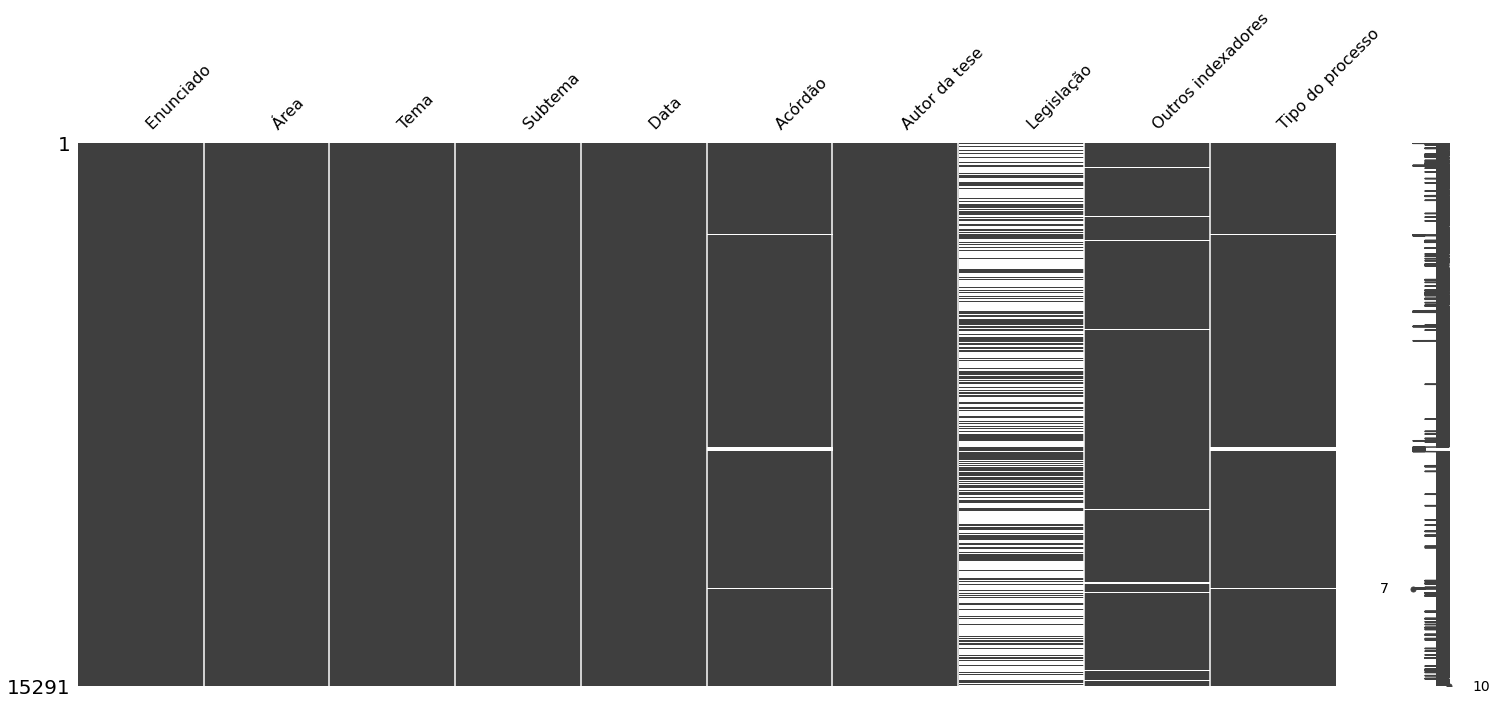

In [14]:
#Plotar matriz de dados faltantes
import missingno as msno
msno.matrix(df)

In [15]:
# Verificar percentil de dados faltantes
tm = len(df)
for cl in df.columns:
    lista = list(df[cl].unique())
    qtnull = df[cl].isnull().sum()
    print(cl,'%', round((qtnull / tm) * 100))


 Enunciado  % 0
 Área  % 0
 Tema  % 0
 Subtema  % 0
 Data % 0
 Acórdão  % 1
 Autor da tese  % 0
 Legislação  % 61
 Outros indexadores  % 1
 Tipo do processo  % 1


In [16]:
# Verificar as informações gerais do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0    Enunciado            15291 non-null  object
 1    Área                 15291 non-null  object
 2    Tema                 15291 non-null  object
 3    Subtema              15291 non-null  object
 4    Data                 15291 non-null  object
 5    Acórdão              15064 non-null  object
 6    Autor da tese        15291 non-null  object
 7    Legislação           5958 non-null   object
 8    Outros indexadores   15095 non-null  object
 9    Tipo do processo     15064 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB


In [17]:
# Valores únicos por coluna do DataFrame
df.nunique()

 Enunciado              14367
 Área                      10
 Tema                     395
 Subtema                  835
 Data                    1568
 Acórdão                12194
 Autor da tese             25
 Legislação              3373
 Outros indexadores     10473
 Tipo do processo          33
dtype: int64

In [18]:
# Quantidade de registros (linhas) para cada 'Área'
df[' Área '].value_counts()

Pessoal                    3989
Licitação                  3002
Responsabilidade           2757
Direito Processual         2164
Contrato Administrativo    1026
Convênio                    760
Competência do TCU          657
Finanças Públicas           418
Gestão Administrativa       371
Desestatização              147
Name:  Área , dtype: int64

In [19]:
# Verificar a quantidade de temas por área
df.groupby([' Tema ', ' Área '])[' Área '].count()

 Tema                                                         Área                  
AGU                                                          Gestão Administrativa        6
ANA                                                          Gestão Administrativa        1
ANATEL                                                       Gestão Administrativa        2
ANEEL                                                        Gestão Administrativa        2
ANS                                                          Gestão Administrativa        1
Abandono de cargo                                            Pessoal                      1
Abono de permanência em serviço                              Pessoal                      7
Acesso à informação                                          Competência do TCU          11
                                                             Direito Processual          31
Acordo de cooperação                                         Convênio                  

In [20]:
# Verificar a quantidade de subtema por área

df.groupby([' Subtema ', ' Área '])[' Área '].count()

 Subtema          Área             
AGU              Competência do TCU      4
ANATEL           Pessoal                 1
Abate-teto       Finanças Públicas       1
Abrangência      Competência do TCU    302
                 Direito Processual     78
                                      ... 
Índice contábil  Licitação              27
Órgão autônomo   Finanças Públicas       3
Órgão público    Convênio                1
Ônus da prova    Direito Processual     63
                 Responsabilidade        6
Name:  Área , Length: 1130, dtype: int64

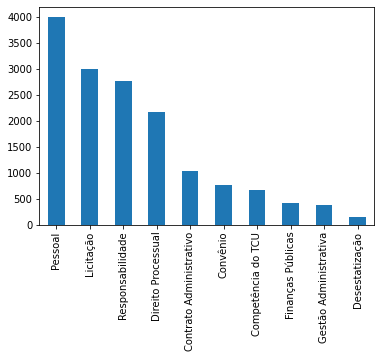

In [21]:
#Histograma das categorias encontradas na coluna 'área'
#Indica a frequência (nº de registros) para cada categoria (cada valor único da coluna 'área')
df[' Área '].value_counts().plot(kind='bar');

# **Separação de Dados de Treino e Teste**






In [27]:
# Separa os dados de treino e teste (proporção 80/20)

X_train, X_test, y_train, y_test = train_test_split(df.Enunciado, df.classe, test_size=0.2, 
                                                    stratify=df.classe,random_state=42)

In [28]:
pd.Series(X_test.index).value_counts()

6143     1
2632     1
13660    1
7515     1
13658    1
        ..
4767     1
10910    1
6812     1
5797     1
4096     1
Length: 3059, dtype: int64

In [29]:
pd.Series(df['Enunciado'].index).value_counts()

2047     1
10864    1
2692     1
12931    1
14978    1
        ..
9502     1
13596    1
3355     1
1306     1
0        1
Length: 15291, dtype: int64

In [30]:
X_train[:10], y_train[:10]

(11935    A Administração deve adotar controles eficazes...
 13936    A falta de obtenção do título de pós-graduação...
 12124    É inconstitucional a criação de funções gratif...
 12349    É possível a concessão simultânea de pensão à ...
 5559     SÚMULA TCU 253: Comprovada a inviabilidade téc...
 503      É competência constitucional do TCU aferir a i...
 12352    Na hipótese de exíguo tempo de serviço faltant...
 9238     A contratação de profissionais médicos ou dent...
 13414    O município responde pela não aplicação de con...
 2016     Os recursos provenientes das doações e patrocí...
 Name: Enunciado, dtype: object, 11935    8
 13936    9
 12124    8
 12349    8
 5559     7
 503      0
 12352    8
 9238     8
 13414    9
 2016     2
 Name: classe, dtype: int8)

In [31]:
# Confere a proporção das classes nos dados de treino e de teste
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (12232,) 
 8    0.260873
7    0.196288
9    0.180265
4    0.141514
1    0.067119
2    0.049706
0    0.043002
5    0.027305
6    0.024281
3    0.009647
Name: classe, dtype: float64 

TESTE  :  (3059,) 
 8    0.260870
7    0.196469
9    0.180451
4    0.141550
1    0.067015
2    0.049689
0    0.042824
5    0.027460
6    0.024191
3    0.009480
Name: classe, dtype: float64


### Random Over Sampler (balanceamento da classe de treino)

In [32]:
ros = RandomOverSampler(random_state=0)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train.to_frame(), y_train)

# **Pré Processamento**

In [22]:
df[' Área '] = pd.Categorical(df[' Área '])

df['classe'] = df[' Área '].cat.codes

df.keys()

Index([' Enunciado ', ' Área ', ' Tema ', ' Subtema ', ' Data', ' Acórdão ',
       ' Autor da tese ', ' Legislação ', ' Outros indexadores ',
       ' Tipo do processo ', 'classe'],
      dtype='object')

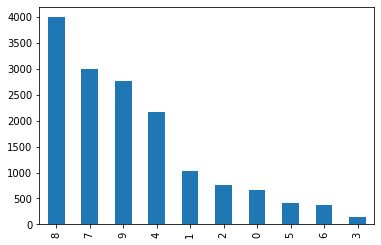

In [23]:
#Histograma das categorias encontradas na coluna 'área'
#Indica a frequência (nº de registros) para cada categoria (cada valor único da coluna 'área')
df['classe'].value_counts().plot(kind='bar');

In [24]:
df.columns = ['Enunciado', 'Area', 'Tema', 'Subtema', 'Data', 'Acordao',
       'AutorTese', 'Legislacao', 'OutrosIndexadores',
       'TipoProcesso', 'classe']

In [25]:
df.columns

Index(['Enunciado', 'Area', 'Tema', 'Subtema', 'Data', 'Acordao', 'AutorTese',
       'Legislacao', 'OutrosIndexadores', 'TipoProcesso', 'classe'],
      dtype='object')

In [26]:
df.Enunciado

0        <b>SÚMULA TCU 88 (REVOGADA) :</b> <s>Não é da ...
1        <b>SÚMULA TCU 62 (REVOGADA) :</b> <s>Ao examin...
2        SÚMULA TCU 8: Compete ao Tribunal de Contas o ...
3        SÚMULA TCU 156: A Lei nº 6.525, de 11/04/78, n...
4        SÚMULA TCU 9: Está sujeito ao Tribunal de Cont...
                               ...                        
15286    Não cabe a declaração de inidoneidade pelo TCU...
15287    A emissão de parecer jurídico carente de funda...
15288    Caso os ofícios citatórios não façam menção à ...
15289    Não se pode atribuir responsabilidade a integr...
15290    A sanção de declaração de inidoneidade para pa...
Name: Enunciado, Length: 15291, dtype: object

## Term Frequency – Inverse Document Frequency (TF-IDF)

### Teste Retirando Stopwords e apenas 500 palavras em no máximo 70% dos documentos e mínimo de 3 documentos


In [33]:
# instancia o transform TfidfVectorizer sem stopwords
regex =r'(?u)\b[A-Za-z]+\b'
tfidf_vectorizer_no_stop_words = TfidfVectorizer(max_features=500, max_df=0.7, min_df=3, stop_words=stopwords)
# tokeniza e cria o vocabulário
tfidf_vectorizer_no_stop_words.fit(X_train)
# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer_no_stop_words.vocabulary_)

print('\nPeso de cada palavra do vocabulário: ')
print(tfidf_vectorizer_no_stop_words.idf_)

Vocabulário: 
{'administração': 38, 'deve': 166, 'vistas': 495, 'evitar': 205, 'servidores': 448, 'cargo': 92, 'função': 234, 'confiança': 116, 'direta': 173, 'processo': 389, 'comissão': 102, 'autoridade': 74, 'legal': 286, 'falta': 217, 'título': 482, 'ausência': 73, 'defesa': 155, 'publicação': 404, 'dever': 169, 'erário': 199, 'valores': 488, 'recebidos': 418, 'conhecimento': 119, 'contribuição': 137, 'desenvolvimento': 162, 'funções': 235, 'meio': 304, 'ato': 70, 'administrativo': 36, 'possível': 368, 'concessão': 110, 'pensão': 354, 'ainda': 44, 'judicial': 278, 'união': 484, 'instituidor': 264, 'benefício': 82, 'situação': 454, 'ser': 445, 'outros': 343, 'elementos': 188, 'súmula': 462, 'tcu': 466, 'técnico': 480, 'econômica': 181, 'objeto': 330, 'licitação': 293, 'termos': 471, 'legislação': 288, 'itens': 276, 'natureza': 318, 'específica': 201, 'empresas': 193, 'percentual': 355, 'preço': 382, 'global': 241, 'obra': 331, 'devem': 167, 'incidência': 253, 'despesas': 163, 'relaç

In [34]:
print(tfidf_vectorizer_no_stop_words.vocabulary_)

{'administração': 38, 'deve': 166, 'vistas': 495, 'evitar': 205, 'servidores': 448, 'cargo': 92, 'função': 234, 'confiança': 116, 'direta': 173, 'processo': 389, 'comissão': 102, 'autoridade': 74, 'legal': 286, 'falta': 217, 'título': 482, 'ausência': 73, 'defesa': 155, 'publicação': 404, 'dever': 169, 'erário': 199, 'valores': 488, 'recebidos': 418, 'conhecimento': 119, 'contribuição': 137, 'desenvolvimento': 162, 'funções': 235, 'meio': 304, 'ato': 70, 'administrativo': 36, 'possível': 368, 'concessão': 110, 'pensão': 354, 'ainda': 44, 'judicial': 278, 'união': 484, 'instituidor': 264, 'benefício': 82, 'situação': 454, 'ser': 445, 'outros': 343, 'elementos': 188, 'súmula': 462, 'tcu': 466, 'técnico': 480, 'econômica': 181, 'objeto': 330, 'licitação': 293, 'termos': 471, 'legislação': 288, 'itens': 276, 'natureza': 318, 'específica': 201, 'empresas': 193, 'percentual': 355, 'preço': 382, 'global': 241, 'obra': 331, 'devem': 167, 'incidência': 253, 'despesas': 163, 'relação': 430, 'dem

In [35]:
# encode enunciados - sem stopwords
tfidf_vector_1 = tfidf_vectorizer_no_stop_words.transform(X_train)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector_1.shape)


Dimensões da matrix: 
(12232, 500)


In [36]:
# mostra os enunciados codificados
val_1 = tfidf_vectorizer_no_stop_words.fit_transform(X_train)
feature_names_1 = tfidf_vectorizer_no_stop_words.get_feature_names_out()
dfVocab_1= pd.DataFrame(val_1.toarray(), columns = feature_names_1)
print(dfVocab_1.shape)
dfVocab_1

(12232, 500)


,10,11,112,12,13,1990,1991,1992,1993,1994,1997,1998,1º,20,2001,2003,2004,2005,24,2º,37,3º,40,443,4º,58,5º,666,6º,acerca,acordao_decisao_tcu,acordo,acumulação,acórdão,adicional,administrativa,administrativo,administrativos,administração,admite,...,suficiente,superior,súmula,tais,tal,tanto,tcu,tempo,tendo,ter,termo,termos,todos,tomada,total,trabalho,transferidos,transferência,tribunal,técnica,técnico,técnicos,título,unitários,união,uso,utilização,valor,valores,vantagem,vantagens,vedada,vez,vigência,vista,vistas,âmbito,órgão,órgãos,único
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.141534,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.252731,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.303182,0.0,0.000000,0.0,0.000000,0.0,0.230718,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53996,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.263295,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.193521,0.000000,0.0,0.0,0.114999,0.000000,0.0,0.0,0.0,0.187416,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.209993,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12227,0.0,0.0,0.0,0.0,0.0,0.117695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148537,0.0,0.0,0.0,0.0,0.117515,0.0,0.0,0.0,0.0,0.14557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.141289,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.124004,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
12228,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.201208,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
12229,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0

### Teste Retirando Stopwords e Números, limitado a apenas 500 palavras em no máximo 70% dos documentos e mínimo de 3 documentos




In [37]:
# instancia o transform TfidfVectorizer sem números 
regex =r'(?u)\b[A-Za-z]+\b'
tfidf_vectorizer_no_numbers = TfidfVectorizer(max_features=500, max_df=0.7, min_df=3, stop_words=stopwords, token_pattern=regex)
# tokeniza e cria o vocabulário
tfidf_vectorizer_no_numbers.fit(X_train)
# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer_no_numbers.vocabulary_)

print('\nPeso de cada palavra do vocabulário: ')
print(tfidf_vectorizer_no_numbers.idf_)

Vocabulário: 
{'deve': 138, 'adotar': 8, 'vistas': 498, 'evitar': 194, 'servidores': 448, 'cargo': 54, 'direta': 148, 'estabelecimento': 187, 'processo': 386, 'autoridade': 38, 'observar': 330, 'legal': 283, 'falta': 207, 'defesa': 123, 'dever': 141, 'valores': 490, 'recebidos': 412, 'conhecimento': 83, 'adquirido': 9, 'desenvolvimento': 129, 'meio': 299, 'ato': 36, 'administrativo': 5, 'ainda': 14, 'judicial': 275, 'instituidor': 258, 'ser': 445, 'comprovada': 73, 'outros': 339, 'elementos': 165, 'tcu': 466, 'objeto': 327, 'termos': 473, 'itens': 272, 'fornecimento': 227, 'materiais': 294, 'equipamentos': 180, 'natureza': 313, 'empresas': 172, 'percentual': 353, 'global': 237, 'obra': 328, 'devem': 139, 'despesas': 131, 'bdi': 42, 'demais': 124, 'constitucional': 93, 'despesa': 130, 'pagamento': 340, 'tempo': 468, 'direito': 147, 'aposentadoria': 28, 'atividade': 34, 'servidor': 447, 'afronta': 11, 'apenas': 24, 'economicidade': 158, 'porquanto': 368, 'profissional': 390, 'antes': 23,

In [38]:
print(tfidf_vectorizer_no_numbers.vocabulary_)

{'deve': 138, 'adotar': 8, 'vistas': 498, 'evitar': 194, 'servidores': 448, 'cargo': 54, 'direta': 148, 'estabelecimento': 187, 'processo': 386, 'autoridade': 38, 'observar': 330, 'legal': 283, 'falta': 207, 'defesa': 123, 'dever': 141, 'valores': 490, 'recebidos': 412, 'conhecimento': 83, 'adquirido': 9, 'desenvolvimento': 129, 'meio': 299, 'ato': 36, 'administrativo': 5, 'ainda': 14, 'judicial': 275, 'instituidor': 258, 'ser': 445, 'comprovada': 73, 'outros': 339, 'elementos': 165, 'tcu': 466, 'objeto': 327, 'termos': 473, 'itens': 272, 'fornecimento': 227, 'materiais': 294, 'equipamentos': 180, 'natureza': 313, 'empresas': 172, 'percentual': 353, 'global': 237, 'obra': 328, 'devem': 139, 'despesas': 131, 'bdi': 42, 'demais': 124, 'constitucional': 93, 'despesa': 130, 'pagamento': 340, 'tempo': 468, 'direito': 147, 'aposentadoria': 28, 'atividade': 34, 'servidor': 447, 'afronta': 11, 'apenas': 24, 'economicidade': 158, 'porquanto': 368, 'profissional': 390, 'antes': 23, 'nova': 320, 

In [39]:
# encode enunciados - sem stopwords e números
tfidf_vector_2 = tfidf_vectorizer_no_numbers.transform(X_train)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector_2.shape)


Dimensões da matrix: 
(12232, 500)


In [40]:
print(tfidf_vector_1.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [41]:
print(tfidf_vector_2.toarray())

[[0.         0.         0.         ... 0.         0.30114049 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.31773175 0.        ]
 [0.         0.         0.         ... 0.         0.         0.36160405]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [42]:
# mostra os enunciados codificados
val_2 = tfidf_vectorizer_no_numbers.fit_transform(X_train)
feature_names_2 = tfidf_vectorizer_no_numbers.get_feature_names_out()
dfVocab_2= pd.DataFrame(val_2.toarray(), columns = feature_names_2)
print(dfVocab_2.shape)
dfVocab_2

(12232, 500)


,acerca,acordo,adicional,administradores,administrativa,administrativo,administrativos,admite,adotar,adquirido,afasta,afronta,agente,agentes,ainda,ajuste,amparo,ampla,ano,anos,ante,anterior,anteriormente,antes,apenas,aplica,aplicada,apoio,aposentadoria,art,arts,assim,atendimento,atestados,atividade,atividades,ato,atos,autoridade,autos,...,suficiente,sujeita,superior,tais,tal,tanto,tcu,tecnologia,tempo,tendo,ter,terceiros,termo,termos,ti,tipo,todas,todos,tomada,total,trabalho,transferidos,trata,tratar,tribunal,unidade,uso,utilizados,validade,valor,valores,vantagem,vantagens,vedada,vencimento,vencimentos,vez,vista,vistas,vpni
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.304776,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.294172,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.301140,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.397013,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275020,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.656816,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.505121,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.335652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.119116,0.0,0.000000,0.0,0.0,0.0,0.0,0.194127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12227,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.120708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213531,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
12228,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.407881,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
12229,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.238251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

# **Modelos**

## Modelo 1
**SGD Classifier**
associado ao TF-IDF sem stopwords, 5000 palavras, presentes em no máximo 70% dos enunciados e no mínimo em 3 

In [43]:
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, max_df=0.7, min_df=3, stop_words=stopwords)),
    ('clf', SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-06)) # default hinge. to get proba=log or modified_huber
])

In [44]:
%%time
# Treine o modelo(fit)
classificador_1 = pipeline_1.fit(X_train, y_train)

CPU times: user 1.29 s, sys: 3.27 ms, total: 1.29 s
Wall time: 1.31 s


In [45]:
classificador_1.score(X_test,y_test)

0.883949002942138

In [46]:
 # Faça a predição nos dados de teste
 predicted_1 = classificador_1.predict(X_test)

In [47]:
f1_score(y_test, predicted_1, average='weighted') 

0.8822449616146191

### Avaliação do Modelo 1

In [48]:
print(metrics.classification_report(y_test, predicted_1))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       131
           1       0.81      0.79      0.80       205
           2       0.77      0.76      0.76       152
           3       0.74      0.59      0.65        29
           4       0.89      0.89      0.89       433
           5       0.85      0.69      0.76        84
           6       0.77      0.62      0.69        74
           7       0.89      0.93      0.91       601
           8       0.94      0.98      0.96       798
           9       0.87      0.87      0.87       552

    accuracy                           0.88      3059
   macro avg       0.84      0.79      0.81      3059
weighted avg       0.88      0.88      0.88      3059



In [49]:
df.Area.unique()


['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização', 'Direito Processual', 'Finanças Públicas', 'Gestão Administrativa', 'Licitação', 'Pessoal', 'Responsabilidade']
Categories (10, object): ['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização',
                          ..., 'Gestão Administrativa', 'Licitação', 'Pessoal',
                          'Responsabilidade']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


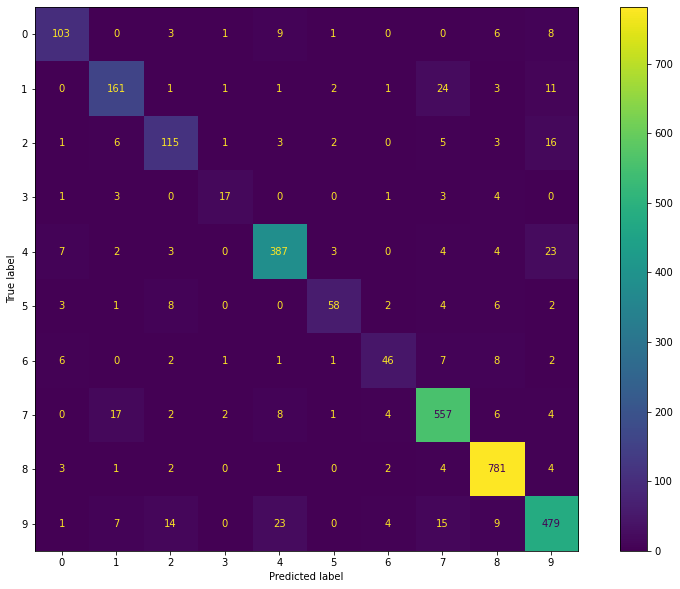

In [50]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(classificador_1, X_test, y_test, values_format='d', ax=ax)

In [51]:
# Mostra os hiperparâmetros usados para treinar o modelo
classificador_1.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, max_features=5000, min_df=3,
                                 stop_words=['de', 'a', 'o', 'que', 'e', 'é',
                                             'do', 'da', 'em', 'um', 'para',
                                             'com', 'não', 'uma', 'os', 'no',
                                             'se', 'na', 'por', 'mais', 'as',
                                             'dos', 'como', 'mas', 'ao', 'ele',
                                             'das', 'à', 'seu', 'sua', ...])),
                ('clf',
                 SGDClassifier(alpha=1e-06, loss='log', penalty='elasticnet'))])>

### Análise das probabilidades das predições do Modelo 1

In [52]:
# text_test = X_test[0:200]
# target_test = y_test[0:200]

In [53]:
# # Mostra as probabilidades das classes nos dados de teste (primeiras 5 jurisprudências)
# prob_preds_1 = classificador_1.predict_proba(text_test)
# prob_preds_1[:5]

##Modelo 2
**SGD Classifier** associado ao TF-IDF sem stopwords, 5000 palavras, presentes em no máximo 70% dos enunciados e no mínimo em 3
Utiliza Random Over Sample (ROS) para balancear as classes no treino


In [54]:
classificador_1_balanced = pipeline_1.fit(X_train_balanced['Enunciado'], y_train_balanced)

In [55]:
classificador_1_balanced.score(X_test,y_test) 

0.8881987577639752

In [56]:
predicted_1_balanced = classificador_1_balanced.predict(X_test)

In [57]:
print(metrics.classification_report(y_test, predicted_1_balanced))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       131
           1       0.82      0.80      0.81       205
           2       0.75      0.80      0.77       152
           3       0.75      0.72      0.74        29
           4       0.89      0.88      0.89       433
           5       0.78      0.76      0.77        84
           6       0.74      0.68      0.70        74
           7       0.92      0.93      0.92       601
           8       0.96      0.97      0.96       798
           9       0.88      0.87      0.87       552

    accuracy                           0.89      3059
   macro avg       0.83      0.82      0.83      3059
weighted avg       0.89      0.89      0.89      3059



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


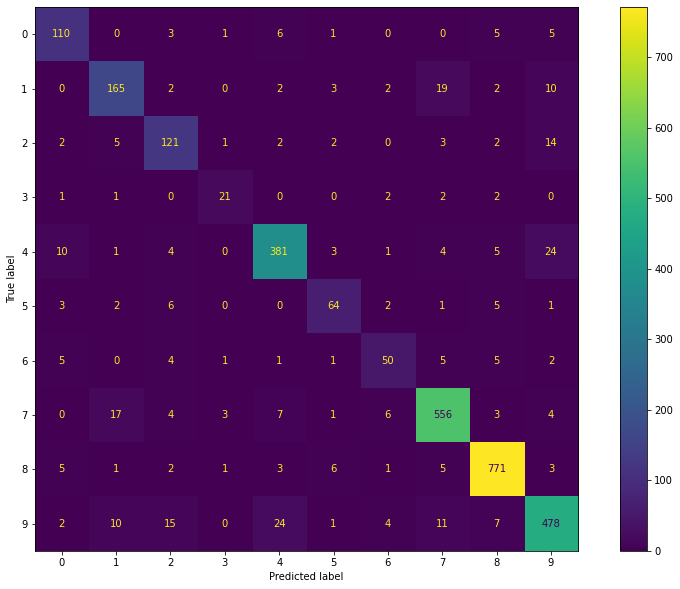

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(classificador_1_balanced, X_test, y_test, values_format='d', ax=ax)

### Análise das probabilidades das predições do Modelo 2

## Modelo 3

SGD Classifier associado ao TF-IDF retiranto stopwords  e números

limitado a 5000 palavras, presentes em no máximo 70% dos enunciados e no mínimo em 3

In [59]:
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, max_df=0.7, min_df=3, stop_words=stopwords, token_pattern=regex)),
    ('clf', SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-06)) # default hinge. to get proba=log or modified_huber
])

In [60]:
%%time
# Treine o modelo(fit)
classificador_2 = pipeline_2.fit(X_train, y_train)

CPU times: user 1.06 s, sys: 4.66 ms, total: 1.06 s
Wall time: 1.07 s


In [61]:
classificador_2.score(X_test,y_test)

0.8394900294213795

In [62]:
 predicted_2 = classificador_2.predict(X_test)

In [63]:
from sklearn.metrics import f1_score
f1_score(y_test, predicted_2, average='weighted') 

0.8361369156128019

In [64]:
print(metrics.classification_report(y_test, predicted_2))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       131
           1       0.81      0.73      0.77       205
           2       0.68      0.69      0.69       152
           3       0.56      0.31      0.40        29
           4       0.84      0.85      0.84       433
           5       0.76      0.56      0.64        84
           6       0.72      0.53      0.61        74
           7       0.83      0.90      0.87       601
           8       0.92      0.96      0.94       798
           9       0.82      0.81      0.81       552

    accuracy                           0.84      3059
   macro avg       0.77      0.71      0.73      3059
weighted avg       0.84      0.84      0.84      3059



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


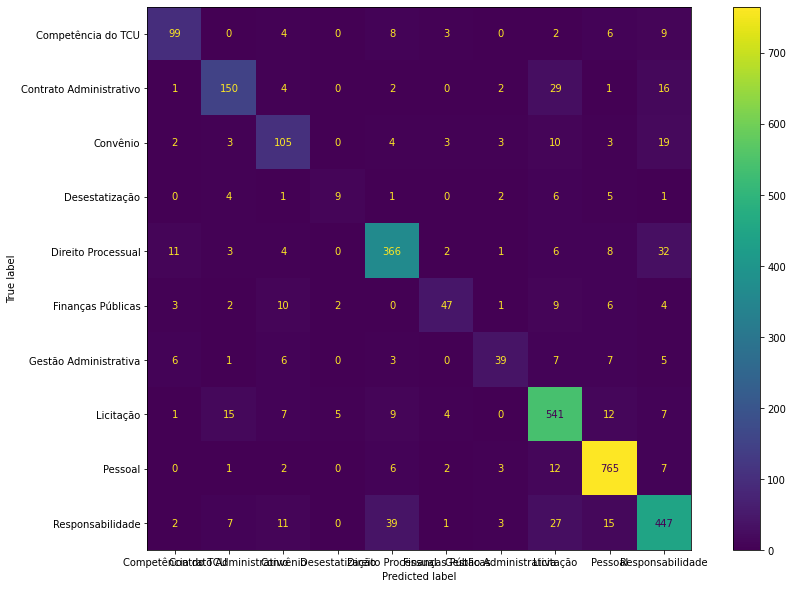

In [65]:
# Mostra os hiperparâmetros usados para treinar o modelo
fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(classificador_2, X_test, y_test, ax=ax, values_format='d', display_labels=['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização', 'Direito Processual', 'Finanças Públicas', 'Gestão Administrativa', 'Licitação', 'Pessoal', 'Responsabilidade'])

In [66]:
# Mostra os hiperparâmetros usados para treinar o modelo
classificador_2.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, max_features=5000, min_df=3,
                                 stop_words=['de', 'a', 'o', 'que', 'e', 'é',
                                             'do', 'da', 'em', 'um', 'para',
                                             'com', 'não', 'uma', 'os', 'no',
                                             'se', 'na', 'por', 'mais', 'as',
                                             'dos', 'como', 'mas', 'ao', 'ele',
                                             'das', 'à', 'seu', 'sua', ...],
                                 token_pattern='(?u)\\b[A-Za-z]+\\b')),
                ('clf',
                 SGDClassifier(alpha=1e-06, loss='log', penalty='elasticnet'))])>

### Análise das probabilidades das predições do modelo 3

In [67]:
prob_preds_2 = classificador_2.predict_proba(X_test)
prob_preds_2[:5]

array([[7.34836592e-06, 1.08600925e-04, 3.01511141e-02, 2.81224265e-05,
        7.83086870e-05, 2.93795363e-06, 2.16430769e-05, 9.60206015e-05,
        9.69500808e-01, 5.09596031e-06],
       [2.64468400e-06, 2.14480419e-05, 2.57990469e-04, 6.87969913e-05,
        2.27957058e-05, 1.42940470e-03, 8.15343416e-02, 5.87634006e-03,
        8.08310487e-01, 1.02475751e-01],
       [1.54723575e-02, 9.07351879e-05, 8.05771650e-01, 1.96462587e-04,
        4.09662862e-05, 7.02365733e-02, 1.05848144e-01, 9.77708357e-05,
        3.33120157e-04, 1.91222047e-03],
       [1.84483122e-04, 1.04013410e-04, 4.48402527e-02, 2.08754910e-04,
        9.47646480e-01, 2.80251103e-05, 1.71268121e-04, 6.16949329e-03,
        6.22357281e-04, 2.48724127e-05],
       [3.06075440e-02, 1.49563724e-08, 2.98448232e-06, 8.55532147e-08,
        1.03353723e-02, 5.57005738e-06, 9.03821353e-05, 2.56801314e-06,
        9.58893410e-01, 6.20685097e-05]])

## Modelo 4

**Random Forest** associado ao TF-IDF sem stopwords, 5000 palavras, presentes em no máximo 70% dos enunciados e no mínimo em 3

In [68]:
#RandomForest

# Define o pipeline incluindo o extrator de 'features do texto e um classificador
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, max_df=0.7, min_df=3, stop_words=stopwords)),
    ('clf', RandomForestClassifier()) # default hinge. to get proba=log or modified_huber
])

In [69]:
%%time
# Treine o modelo(fit)
classificador_3 = pipeline_3.fit(X_train, y_train)

CPU times: user 13.4 s, sys: 74.5 ms, total: 13.5 s
Wall time: 13.4 s


In [70]:
classificador_3.score(X_test,y_test) 

0.84472049689441

In [71]:
classificador_3.score(X_test,y_test)

0.84472049689441

In [72]:
 # Faça a predição nos dados de teste
 predicted_3 = classificador_3.predict(X_test)

In [73]:
# Modelo 3 - f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
from sklearn.metrics import f1_score
f1_score(y_test, predicted_3, average='weighted') # harmonic mean of the precision and recall - F1 = 2 * (precision * recall) / (precision + recall)

0.8349937979611942

In [74]:
print(metrics.classification_report(y_test, predicted_3))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       131
           1       0.81      0.64      0.72       205
           2       0.75      0.66      0.70       152
           3       1.00      0.07      0.13        29
           4       0.88      0.85      0.87       433
           5       0.84      0.44      0.58        84
           6       1.00      0.41      0.58        74
           7       0.79      0.96      0.87       601
           8       0.90      0.97      0.93       798
           9       0.84      0.85      0.84       552

    accuracy                           0.84      3059
   macro avg       0.86      0.66      0.70      3059
weighted avg       0.85      0.84      0.83      3059



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


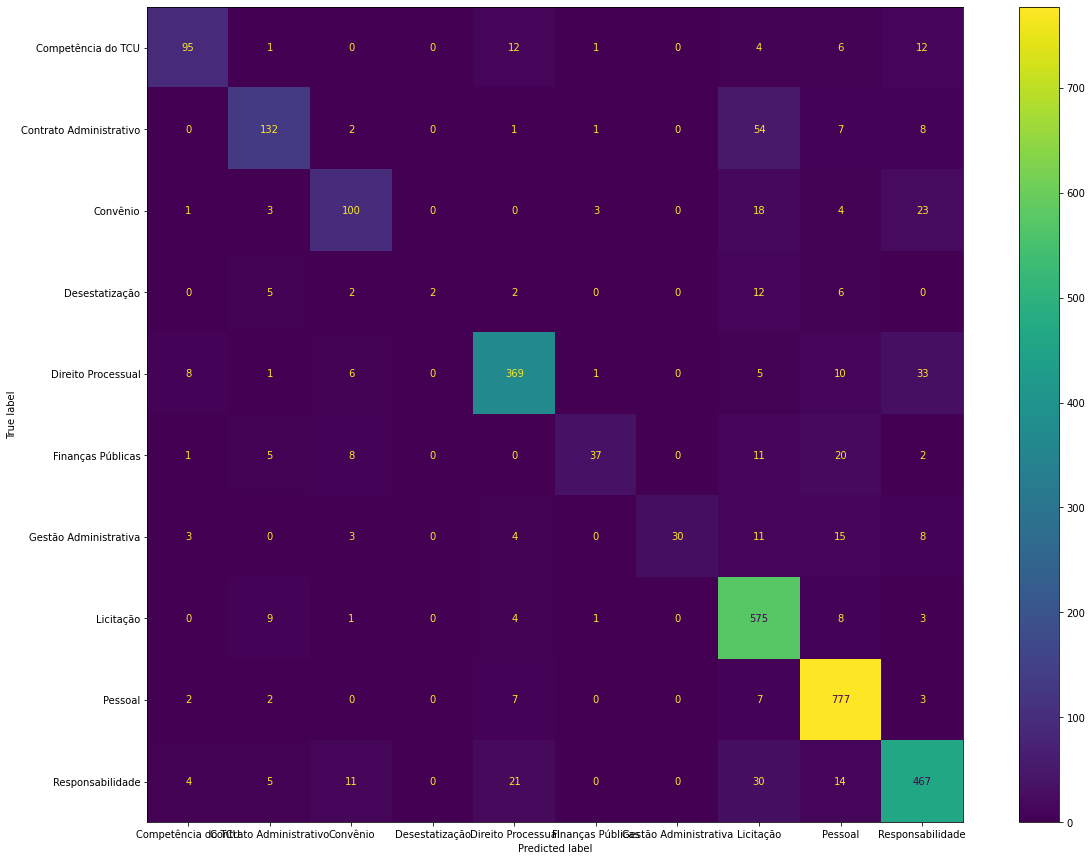

In [75]:
fig, ax = plt.subplots(figsize=(20, 15))
plot_confusion_matrix(classificador_3, X_test, y_test, values_format='d', ax=ax, display_labels=['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização', 'Direito Processual', 'Finanças Públicas', 'Gestão Administrativa', 'Licitação', 'Pessoal', 'Responsabilidade'])

In [76]:
# Mostra os hiperparâmetros usados para treinar o modelo
classificador_3.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, max_features=5000, min_df=3,
                                 stop_words=['de', 'a', 'o', 'que', 'e', 'é',
                                             'do', 'da', 'em', 'um', 'para',
                                             'com', 'não', 'uma', 'os', 'no',
                                             'se', 'na', 'por', 'mais', 'as',
                                             'dos', 'como', 'mas', 'ao', 'ele',
                                             'das', 'à', 'seu', 'sua', ...])),
                ('clf', RandomForestClassifier())])>

# Observação dos resultados

In [77]:
# text_test = X_test[0:200]
# target_test = y_test[0:200]

In [78]:
len(X_test)

3059

In [79]:
len(y_test)

3059

In [80]:
y_test.value_counts()

8    798
7    601
9    552
4    433
1    205
2    152
0    131
5     84
6     74
3     29
Name: classe, dtype: int64

## Modelo 1 

In [81]:
# Mostra as probabilidades das classes nos dados de teste (primeiras 5 jurisprudências)
prob_preds_1 = classificador_1.predict_proba(X_test)
prob_preds_1[:5]

array([[3.31185277e-05, 1.44402581e-04, 2.71207437e-02, 3.39026145e-05,
        2.39453264e-04, 3.14183514e-05, 1.65829223e-04, 7.17341285e-04,
        9.71408603e-01, 1.05187834e-04],
       [1.07414378e-04, 3.83159137e-03, 6.96663625e-02, 2.35693123e-04,
        3.01246657e-05, 5.41172289e-03, 2.44183600e-01, 2.45453310e-02,
        1.87410413e-03, 6.50114056e-01],
       [1.24116418e-02, 3.93842029e-05, 1.11235223e-01, 3.38615920e-04,
        5.17057150e-04, 8.35997408e-01, 3.01662248e-02, 1.08533073e-04,
        8.76533723e-03, 4.20574233e-04],
       [8.83094193e-04, 1.59354226e-04, 3.14397240e-02, 3.49213041e-04,
        9.51764512e-01, 1.55002742e-03, 7.00879885e-04, 4.14496733e-03,
        8.96893079e-03, 3.92969861e-05],
       [3.53914045e-02, 3.05672572e-06, 1.11502845e-05, 2.05781920e-05,
        1.03354445e-01, 9.26458017e-05, 7.77186202e-05, 3.38578313e-05,
        8.60998229e-01, 1.69137567e-05]])

In [82]:
X_test.shape

(3059,)

In [83]:
# Cria dataframe para conferência da confiaça do modelo 1 em cada predição (probabilidades)
df_prob_1 = pd.DataFrame(columns=['texto','actual','predicted', 'prob_comptTCU(0)', 'prob_contra(1)', 'prob_conven(2)','prob_desestatiz(3)','prob_dirproc(4)', 'prob_financa(5)', 'prob_gadm(6)', 'prob_licit(7)', 'prob_pessoal(8)', 'prob_resp(9)'])
df_prob_1['texto'] = X_test
df_prob_1['actual'] = y_test
df_prob_1['predicted'] = classificador_1.predict(X_test)
df_prob_1['prob_comptTCU(0)'] = np.round(prob_preds_1[0:,0],6).tolist()
df_prob_1['prob_contra(1)'] = np.round(prob_preds_1[0:,1],6).tolist()
df_prob_1['prob_respo(2)'] = np.round(prob_preds_1[0:,2],6).tolist()
df_prob_1['prob_conven(3)'] = np.round(prob_preds_1[0:,3],6).tolist()
df_prob_1['prob_dirproc(4)'] = np.round(prob_preds_1[0:,4],6).tolist()
df_prob_1['prob_financa(5)'] = np.round(prob_preds_1[0:,5],6).tolist()
df_prob_1['prob_gadm(6)'] = np.round(prob_preds_1[0:,6],6).tolist()
df_prob_1['prob_licit(7)'] = np.round(prob_preds_1[0:,7],6).tolist()
df_prob_1['prob_pessoal(8)'] = np.round(prob_preds_1[0:,8],6).tolist()
df_prob_1['prob_resp(9)'] = np.round(prob_preds_1[0:,9],6).tolist()

print(df_prob_1.shape)
df_prob_1.head()

(3059, 15)


,texto,actual,predicted,prob_comptTCU(0),prob_contra(1),prob_conven(2),prob_desestatiz(3),prob_dirproc(4),prob_financa(5),prob_gadm(6),prob_licit(7),prob_pessoal(8),prob_resp(9),prob_respo(2),prob_conven(3)
10639,É ilegal o cômputo de tempo das atividades de ...,8,8,0.000033,0.000144,NaN,NaN,0.000239,0.000031,0.000166,0.000717,0.971409,0.000105,0.027121,0.000034
14465,A ausência de rodízio de membros das comissões...,9,9,0.000107,0.003832,NaN,NaN,0.000030,0.005412,0.244184,0.024545,0.001874,0.650114,0.069666,0.000236
4924,Podem ser aplicados aos Fundos Constitucionais...,5,5,0.012412,0.000039,NaN,NaN,0.000517,0.835997,0.030166,0.000109,0.008765,0.000421,0.111235,0.000339
4493,Os relatórios de vistoria <i>in loco</i> dos ó...,4,4,0.000883,0.000159,NaN,NaN,0.951765,0.001550,0.000701,0.004145,0.008969,0.000039,0.031440,0.000349
10030,O exame levado a efeito pelo TCU sobre os atos...,8,8,0.035391,0.000003,NaN,NaN,0.103354,0.000093,0.000078,0.000034,0.860998,0.000017,0.000011,0.000021


In [84]:
pd.Series(df_prob_1.index).value_counts()

6143     1
2632     1
13660    1
7515     1
13658    1
        ..
4767     1
10910    1
6812     1
5797     1
4096     1
Length: 3059, dtype: int64

In [85]:
pd.Series(X_test.index).value_counts()

6143     1
2632     1
13660    1
7515     1
13658    1
        ..
4767     1
10910    1
6812     1
5797     1
4096     1
Length: 3059, dtype: int64

In [86]:
# Listar predições do modelo para classe=9 (classe minoritária) que estão erradas e suas probabilidades.
print(df_prob_1[(df_prob_1['predicted'] == 9) & (df_prob_1['actual'] != df_prob_1['predicted']) & (df_prob_1['prob_resp(9)'] < 0.9)] [['texto']])

                                                   texto
2428   Após executado o objeto de convênio, o cuidado...
7882   Permite-se a correção dos preços antes da assi...
8428   Empresa em litígio com a Fazenda Pública, em a...
1167   É objetiva a responsabilidade do construtor no...
861    A execução de contrato deve ser acompanhada po...
1041   É cabível a utilização de estudos econométrico...
159    A jurisdição do TCU alcança a aplicação de rec...
4591   Para a instauração de tomada de contas especia...
502    Eventuais constatações acerca da aplicação de ...
34     As seguradoras que atuam como agentes executor...
4906   O indicador estoque da dívida pública/estoque ...
2785   Não cabe a instauração de incidente de uniform...
2368   A Administração Pública é obrigada a manter a ...
5247   É indevida a contratação institucional de serv...
4426   É possível a aplicação da multa do art. 58 da ...
2945   É a demonstração da boa-fé objetiva - conduta ...
1481   A antecipação do prazo d

In [87]:
md1_9 = (df_prob_1[(df_prob_1['predicted'] == 9) & (df_prob_1['actual'] != df_prob_1['predicted']) & (df_prob_1['prob_resp(9)'] < 0.9)] [['texto']])

In [88]:
len(md1_9) # enunciados da classe 9 que o modelo previu errado

47

In [89]:
md1_4 = (df_prob_1[(df_prob_1['predicted'] == 4) & (df_prob_1['actual'] != df_prob_1['predicted']) & (df_prob_1['prob_dirproc(4)'] < 0.9)] [['texto']])

In [90]:
len(md1_4)

37

In [91]:
#Enunciado da classe 9 que o modelo errou a predição
df_prob_1['texto'][600]

'Embora não seja da competência do TCU definir a estratégia de empresa estatal para a obtenção de valores pagos indevidamente, cabe ao Tribunal e ao sistema de controle interno avaliar a razoabilidade da estratégia adotada na busca do ressarcimento.'

In [92]:
#Enunciado da classe 9 que o modelo errou a predição
df_prob_1['texto'][159]

'A jurisdição do TCU alcança a aplicação de recursos financeiros oriundos de acordo de empréstimo entre a República Federativa do Brasil e organismo internacional, porquanto constitui obrigação de natureza pecuniária pela qual a União responde perante credor externo. '

In [93]:
# Listar predições do modelo para classe=9 (classe minoritária) que estão erradas e suas probabilidades.
print(df_prob_1[(df_prob_1['predicted'] == 4) & (df_prob_1['actual'] != df_prob_1['predicted']) & (df_prob_1['prob_dirproc(4)'] < 0.9)] [['texto']])

                                                   texto
15112  Uma vez formalizado o processo de cobrança exe...
14011  A avaliação da prescrição, embora seja matéria...
6730   A capacidade técnico-operacional da empresa nã...
1415   Dada a natureza genérica de tributos como Cofi...
12812  Os sucessores somente devem ser chamados aos a...
13917  O gestor deve provar a boa e regular aplicação...
6010   O direito à interposição de recurso em process...
2107   Considera-se regular a contratação temporária ...
217    É cabível ao TCU adentrar o mérito administrat...
315    A apuração de possível cometimento de crimes c...
14685  No caso de indícios de fraude à licitação, dev...
8579   SÚMULA TCU 14: Aplicam-se, no que couber, aos ...
12840  A ocorrência de caso fortuito ou de força maio...
14382  A ausência de regular procedimento licitatório...
12544  SÚMULA TCU 170: Não se inclui entre os favores...
5333   Mudanças que sugerem novo quadro populacional,...
8388   Qualquer modificação dos

In [94]:
#Enunciado da classe 4 que o modelo errou a predição
df_prob_1['texto'][8090]

'A redação dos editais deve ser clara e objetiva de forma a evitar erros ou contradições que dificultem seu entendimento ou levem a interpretações equivocadas.'

In [95]:
df.shape

(15291, 11)

In [96]:
df_prob_1.columns

Index(['texto', 'actual', 'predicted', 'prob_comptTCU(0)', 'prob_contra(1)',
       'prob_conven(2)', 'prob_desestatiz(3)', 'prob_dirproc(4)',
       'prob_financa(5)', 'prob_gadm(6)', 'prob_licit(7)', 'prob_pessoal(8)',
       'prob_resp(9)', 'prob_respo(2)', 'prob_conven(3)'],
      dtype='object')

In [97]:
df_prob_1.iloc[0:3063, ].sort_values(by='actual')

,texto,actual,predicted,prob_comptTCU(0),prob_contra(1),prob_conven(2),prob_desestatiz(3),prob_dirproc(4),prob_financa(5),prob_gadm(6),prob_licit(7),prob_pessoal(8),prob_resp(9),prob_respo(2),prob_conven(3)
216,As Fundações de Apoio são obrigadas a fornecer...,0,2,0.028000,0.000236,NaN,NaN,0.000240,0.000721,0.000028,0.000002,0.000482,0.109203,0.860829,0.000258
58,"Não é competência do TCU, por caracterizar a t...",0,0,0.979309,0.000031,NaN,NaN,0.015450,0.000004,0.000027,0.000629,0.000111,0.003524,0.000483,0.000432
87,"Cabe ao TCU, respaldado em suas atribuições co...",0,0,0.941940,0.000024,NaN,NaN,0.010086,0.000003,0.045340,0.000625,0.001604,0.000175,0.000071,0.000132
230,O TCU é competente para fiscalizar a aplicação...,0,0,0.997195,0.000001,NaN,NaN,0.000613,0.001362,0.000001,0.000000,0.000000,0.000675,0.000152,0.000001
85,O acordo de leniência celebrado pela Administr...,0,0,0.932784,0.000247,NaN,NaN,0.001424,0.000082,0.000534,0.000002,0.000030,0.063670,0.000019,0.001209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13969,É caracterizada a inércia do responsável conve...,9,9,0.000123,0.000067,NaN,NaN,0.020797,0.000106,0.000552,0.004845,0.000119,0.756093,0.216938,0.000359
14141,Para fins do exercício do poder sancionatório ...,9,9,0.001938,0.000115,NaN,NaN,0.003475,0.000631,0.000209,0.000012,0.000043,0.993285,0.000125,0.000167
12740,Quando ocorre o desvio de finalidade na gestão...,9,9,0.015551,0.000059,NaN,NaN,0.001726,0.000017,0.181567,0.017828,0.000206,0.781873,0.000244,0.000930
14752,A ausência de motivação na análise de recursos...,9,9,0.000010,0.000003,NaN,NaN,0.000001,0.000019,0.000044,0.334304,0.000001,0.664152,0.001410,0.000056


## Modelo 2

In [98]:
# Mostra as probabilidades das classes nos dados de teste (primeiras 5 jurisprudências)
prob_preds_1_balanced = classificador_1_balanced.predict_proba(X_test)
prob_preds_1_balanced[:5]


array([[3.31185277e-05, 1.44402581e-04, 2.71207437e-02, 3.39026145e-05,
        2.39453264e-04, 3.14183514e-05, 1.65829223e-04, 7.17341285e-04,
        9.71408603e-01, 1.05187834e-04],
       [1.07414378e-04, 3.83159137e-03, 6.96663625e-02, 2.35693123e-04,
        3.01246657e-05, 5.41172289e-03, 2.44183600e-01, 2.45453310e-02,
        1.87410413e-03, 6.50114056e-01],
       [1.24116418e-02, 3.93842029e-05, 1.11235223e-01, 3.38615920e-04,
        5.17057150e-04, 8.35997408e-01, 3.01662248e-02, 1.08533073e-04,
        8.76533723e-03, 4.20574233e-04],
       [8.83094193e-04, 1.59354226e-04, 3.14397240e-02, 3.49213041e-04,
        9.51764512e-01, 1.55002742e-03, 7.00879885e-04, 4.14496733e-03,
        8.96893079e-03, 3.92969861e-05],
       [3.53914045e-02, 3.05672572e-06, 1.11502845e-05, 2.05781920e-05,
        1.03354445e-01, 9.26458017e-05, 7.77186202e-05, 3.38578313e-05,
        8.60998229e-01, 1.69137567e-05]])

In [99]:
# Cria dataframe para conferência da confiaça do modelo 1 em cada predição (probabilidades)
df_prob_2 = pd.DataFrame(columns=['texto','actual','predicted', 'prob_comptTCU(0)', 'prob_contra(1)', 'prob_conven(2)','prob_desestatiz(3)','prob_dirproc(4)', 'prob_financa(5)', 'prob_gadm(6)', 'prob_licit(7)', 'prob_pessoal(8)', 'prob_resp(9)'])
df_prob_2['texto'] = X_test
df_prob_2['actual'] = y_test
df_prob_2['predicted'] = classificador_1_balanced.predict(X_test)
df_prob_2['prob_comptTCU(0)'] = np.round(prob_preds_1_balanced[0:,0],6).tolist()
df_prob_2['prob_contra(1)'] = np.round(prob_preds_1_balanced[0:,1],6).tolist()
df_prob_2['prob_respo(2)'] = np.round(prob_preds_1_balanced[0:,2],6).tolist()
df_prob_2['prob_conven(3)'] = np.round(prob_preds_1_balanced[0:,3],6).tolist()
df_prob_2['prob_dirproc(4)'] = np.round(prob_preds_1_balanced[0:,4],6).tolist()
df_prob_2['prob_financa(5)'] = np.round(prob_preds_1_balanced[0:,5],6).tolist()
df_prob_2['prob_gadm(6)'] = np.round(prob_preds_1_balanced[0:,6],6).tolist()
df_prob_2['prob_licit(7)'] = np.round(prob_preds_1_balanced[0:,7],6).tolist()
df_prob_2['prob_pessoal(8)'] = np.round(prob_preds_1_balanced[0:,8],6).tolist()
df_prob_2['prob_resp(9)'] = np.round(prob_preds_1_balanced[0:,9],6).tolist()

print(df_prob_2.shape)
df_prob_2.head()

(3059, 15)


,texto,actual,predicted,prob_comptTCU(0),prob_contra(1),prob_conven(2),prob_desestatiz(3),prob_dirproc(4),prob_financa(5),prob_gadm(6),prob_licit(7),prob_pessoal(8),prob_resp(9),prob_respo(2),prob_conven(3)
10639,É ilegal o cômputo de tempo das atividades de ...,8,8,0.000033,0.000144,NaN,NaN,0.000239,0.000031,0.000166,0.000717,0.971409,0.000105,0.027121,0.000034
14465,A ausência de rodízio de membros das comissões...,9,9,0.000107,0.003832,NaN,NaN,0.000030,0.005412,0.244184,0.024545,0.001874,0.650114,0.069666,0.000236
4924,Podem ser aplicados aos Fundos Constitucionais...,5,5,0.012412,0.000039,NaN,NaN,0.000517,0.835997,0.030166,0.000109,0.008765,0.000421,0.111235,0.000339
4493,Os relatórios de vistoria <i>in loco</i> dos ó...,4,4,0.000883,0.000159,NaN,NaN,0.951765,0.001550,0.000701,0.004145,0.008969,0.000039,0.031440,0.000349
10030,O exame levado a efeito pelo TCU sobre os atos...,8,8,0.035391,0.000003,NaN,NaN,0.103354,0.000093,0.000078,0.000034,0.860998,0.000017,0.000011,0.000021


In [440]:
# Listar predições do modelo para classe=9 (classe minoritária) que estão erradas e suas probabilidades.
print(df_prob_2[(df_prob_2['predicted'] == 9) & (df_prob_2['actual'] != df_prob_2['predicted']) & (df_prob_2['prob_resp(9)'] > 0.95)] [['predicted','texto', 'actual']])

      predicted                                              texto  actual
1946          9  A ocorrência de mudanças alinhadas com à conce...       2
3261          9  A mudança de fundamentação de multa aplicada c...       4
3364          9  Sempre que juridicamente viável, deve ser prom...       4
4698          9  O prazo decadencial previsto no art. 54 da Lei...       4
3874          9  A sanção de declaração de inidoneidade (art. 4...       4
3679          9  É cabível, em grau de recurso, modificar o fun...       4
3363          9  Adota-se como termo inicial do prazo para reco...       4


In [436]:
print(df_prob_2['texto'][1946])
print(df_prob_2['texto'][3261])
print(df_prob_2['texto'][3364])
print(df_prob_2['texto'][4698])

A ocorrência de mudanças alinhadas com à concepção do objeto do convênio e de seus objetivos não caracteriza desvio de finalidade ou de objeto, mas falha de natureza formal.
A mudança de fundamentação de multa aplicada com base no art. 57 para o art. 58 da Lei 8.443/1992, a fim de apenar responsável que conseguiu, em grau de recurso, elidir o débito, mas não outras irregularidades analisadas pelo TCU, somente é possível caso o valor da pena pecuniária seja superior ao piso definido no regimento interno, levando-se em consideração a consequente redução da multa em função do afastamento do débito.
Sempre que juridicamente viável, deve ser promovida a citação solidária da sociedade empresária com seu dirigente, nos casos de tomada de contas especial que envolva renúncia fiscal, a exemplo das atividades desenvolvidas com recursos financeiros captados com amparo na Lei 8.313/1991 (Lei Rouanet) , mormente porque a omissão no dever de prestar contas configura infração que merece ser imputada 

In [439]:
# Listar predições do modelo para classe=9 (classe minoritária) que estão erradas e suas probabilidades.
print(df_prob_2[(df_prob_2['predicted'] == 4) & (df_prob_2['actual'] != df_prob_2['predicted']) & (df_prob_2['prob_dirproc(4)'] > 0.95)] [['predicted','texto', 'actual']])

       predicted                                              texto  actual
14869          4  As peculiaridades e circunstâncias do caso con...       9
15172          4  No juízo de responsabilidade acerca do descump...       9
10088          4  As declarações constantes no Sisac possuem pre...       8
12648          4  Eventual demora na instauração da tomada de co...       9
560            4  O acesso irrestrito às informações e documento...       0


In [438]:
print(df_prob_2['texto'][14869])
print(df_prob_2['texto'][15172])
print(df_prob_2['texto'][10088])
print(df_prob_2['texto'][12648])

As peculiaridades e circunstâncias do caso concreto podem justificar a atuação do gestor em sentido diverso daquele indicado pelo TCU em caráter normativo (consulta) .
No juízo de responsabilidade acerca do descumprimento de diligência ou determinação do TCU, devem ser verificadas, objetivamente, as ações adotadas pelo agente público para a efetivação do comando do Tribunal, inexistindo espaço para se reabrir o debate acerca da questão de mérito, possível apenas mediante a via recursal adequada.
As declarações constantes no Sisac possuem presunção de veracidade. Por economia processual, eventual falta ou insuficiência de informação fica suprida pela declaração da autoridade responsável do órgão de origem, confirmada pelo órgão de controle interno. Os gestores têm que fornecer informações corretas e baseadas em provas documentais, sob pena de responsabilização nas esferas civil, penal e administrativa.
Eventual demora na instauração da tomada de contas especial constitui falha de proced

In [101]:
pd.Series(df_prob_2.index).value_counts()

6143     1
2632     1
13660    1
7515     1
13658    1
        ..
4767     1
10910    1
6812     1
5797     1
4096     1
Length: 3059, dtype: int64

In [102]:
df_prob_2['texto'][98]

'Identificando qualquer irregularidade em acordo homologado em juízo, pode o TCU imputar responsabilidade aos agentes públicos que concorreram para a produção do ilícito, com dolo ou culpa, mas não pode expedir ordem que retire a eficácia da sentença judicial, em relação a quem dela se beneficiou, pois seria a desconstituição, por vias oblíquas, de decisão judicial.'

In [103]:
md2_9 = (df_prob_2[(df_prob_2['predicted'] == 9) & (df_prob_2['actual'] != df_prob_2['predicted']) & (df_prob_2['prob_resp(9)'] > 0.90)] [['predicted','texto', 'actual']])

In [104]:
len(md2_9)

16

In [105]:
print(md2_9)

      predicted                                              texto  actual
1946          9  A ocorrência de mudanças alinhadas com à conce...       2
3261          9  A mudança de fundamentação de multa aplicada c...       4
3364          9  Sempre que juridicamente viável, deve ser prom...       4
4706          9  A responsabilidade administrativa atribuída ao...       4
1987          9  O partido político tem de prestar contas de to...       2
4698          9  O prazo decadencial previsto no art. 54 da Lei...       4
3874          9  A sanção de declaração de inidoneidade (art. 4...       4
1985          9  Constitui desvio de objeto, e não desvio de fi...       2
1045          9  Após pronunciamento do STF na Ação Declaratóri...       1
3679          9  É cabível, em grau de recurso, modificar o fun...       4
2429          9  O gestor que aprova a concessão de dinheiro pú...       2
810           9  A contratação de serviços advocatícios para de...       1
1221          9  A degrad

In [106]:
df_prob_2['texto'][1946]

'A ocorrência de mudanças alinhadas com à concepção do objeto do convênio e de seus objetivos não caracteriza desvio de finalidade ou de objeto, mas falha de natureza formal.'

In [107]:
md2_9.sort_index()

,predicted,texto,actual
810,9,A contratação de serviços advocatícios para de...,1
1045,9,Após pronunciamento do STF na Ação Declaratóri...,1
1221,9,"A degradação prematura de pavimento, resultant...",1
1946,9,A ocorrência de mudanças alinhadas com à conce...,2
1985,9,"Constitui desvio de objeto, e não desvio de fi...",2
1987,9,O partido político tem de prestar contas de to...,2
2429,9,O gestor que aprova a concessão de dinheiro pú...,2
3261,9,A mudança de fundamentação de multa aplicada c...,4
3287,9,"Autorizado o parcelamento do débito, antes da ...",4
3363,9,Adota-se como termo inicial do prazo para reco...,4


In [108]:
md2_4 = (df_prob_2[(df_prob_2['predicted'] == 4) & (df_prob_2['actual'] != df_prob_2['predicted']) & (df_prob_2['prob_dirproc(4)'] < 0.9)] [['texto']])

In [109]:
len(md2_4)

37

## Modelo 4

In [110]:
prob_preds_3 = classificador_3.predict_proba(X_test)
prob_preds_3[:5]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.97, 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.03, 0.  , 0.07, 0.72, 0.05, 0.12],
       [0.01, 0.  , 0.14, 0.01, 0.06, 0.27, 0.03, 0.09, 0.28, 0.11],
       [0.  , 0.  , 0.  , 0.  , 0.81, 0.  , 0.04, 0.02, 0.03, 0.1 ],
       [0.04, 0.  , 0.01, 0.  , 0.07, 0.  , 0.  , 0.  , 0.86, 0.02]])

In [111]:
# Cria dataframe para conferência da confiança do modelo 3 (RandomForest) em cada predição (probabilidades)
df_prob_3 = pd.DataFrame(columns=['texto','actual','predicted', 'prob_comptTCU(0)', 'prob_contra(1)', 'prob_conven(2)','prob_desestatiz(3)','prob_dirproc(4)', 'prob_financa(5)', 'prob_gadm(6)', 'prob_licit(7)', 'prob_pessoal(8)', 'prob_resp(9)'])
df_prob_3['texto'] = X_test
df_prob_3['actual'] = y_test
df_prob_3['predicted'] = classificador_3.predict(X_test)
df_prob_3['prob_comptTCU(0)'] = np.round(prob_preds_3[0:,0],6).tolist()
df_prob_3['prob_contra(1)'] = np.round(prob_preds_3[0:,1],6).tolist()
df_prob_3['prob_respo(2)'] = np.round(prob_preds_3[0:,2],6).tolist()
df_prob_3['prob_conven(3)'] = np.round(prob_preds_3[0:,3],6).tolist()
df_prob_3['prob_dirproc(4)'] = np.round(prob_preds_3[0:,4],6).tolist()
df_prob_3['prob_financa(5)'] = np.round(prob_preds_3[0:,5],6).tolist()
df_prob_3['prob_gadm(6)'] = np.round(prob_preds_3[0:,6],6).tolist()
df_prob_3['prob_licit(7)'] = np.round(prob_preds_3[0:,7],6).tolist()
df_prob_3['prob_pessoal(8)'] = np.round(prob_preds_3[0:,8],6).tolist()
df_prob_3['prob_resp(9)'] = np.round(prob_preds_3[0:,9],6).tolist()

print(df_prob_3.shape)
df_prob_3.head()

(3059, 15)


,texto,actual,predicted,prob_comptTCU(0),prob_contra(1),prob_conven(2),prob_desestatiz(3),prob_dirproc(4),prob_financa(5),prob_gadm(6),prob_licit(7),prob_pessoal(8),prob_resp(9),prob_respo(2),prob_conven(3)
10639,É ilegal o cômputo de tempo das atividades de ...,8,8,0.00,0.0,NaN,NaN,0.00,0.00,0.00,0.03,0.97,0.00,0.00,0.00
14465,A ausência de rodízio de membros das comissões...,9,7,0.00,0.0,NaN,NaN,0.03,0.00,0.07,0.72,0.05,0.12,0.00,0.01
4924,Podem ser aplicados aos Fundos Constitucionais...,5,8,0.01,0.0,NaN,NaN,0.06,0.27,0.03,0.09,0.28,0.11,0.14,0.01
4493,Os relatórios de vistoria <i>in loco</i> dos ó...,4,4,0.00,0.0,NaN,NaN,0.81,0.00,0.04,0.02,0.03,0.10,0.00,0.00
10030,O exame levado a efeito pelo TCU sobre os atos...,8,8,0.04,0.0,NaN,NaN,0.07,0.00,0.00,0.00,0.86,0.02,0.01,0.00


In [112]:
# Listar predições do modelo para classe=9 (classe minoritária) que estão erradas e suas probabilidades.
print(df_prob_1[(df_prob_1['predicted'] == 9) & (df_prob_1['actual'] != df_prob_1['predicted']) & (df_prob_1['prob_resp(9)'] < 0.9)] [['texto']])

                                                   texto
2428   Após executado o objeto de convênio, o cuidado...
7882   Permite-se a correção dos preços antes da assi...
8428   Empresa em litígio com a Fazenda Pública, em a...
1167   É objetiva a responsabilidade do construtor no...
861    A execução de contrato deve ser acompanhada po...
1041   É cabível a utilização de estudos econométrico...
159    A jurisdição do TCU alcança a aplicação de rec...
4591   Para a instauração de tomada de contas especia...
502    Eventuais constatações acerca da aplicação de ...
34     As seguradoras que atuam como agentes executor...
4906   O indicador estoque da dívida pública/estoque ...
2785   Não cabe a instauração de incidente de uniform...
2368   A Administração Pública é obrigada a manter a ...
5247   É indevida a contratação institucional de serv...
4426   É possível a aplicação da multa do art. 58 da ...
2945   É a demonstração da boa-fé objetiva - conduta ...
1481   A antecipação do prazo d

In [113]:
md4_9 = (df_prob_3[(df_prob_3['predicted'] == 9) & (df_prob_3['actual'] != df_prob_3['predicted']) & (df_prob_3['prob_resp(9)'] < 0.9)] [['texto']])

In [114]:
len(md4_9)

92

In [115]:
md4_4 = (df_prob_3[(df_prob_3['predicted'] == 4) & (df_prob_3['actual'] != df_prob_3['predicted']) & (df_prob_3['prob_dirproc(4)'] < 0.9)] [['texto']])

In [116]:
len(md4_4)

51

#Modelo Final - otimização de hiperparâmetros
SGDClassifier com dados de treino balanceados


In [135]:
from scipy.stats import uniform, loguniform

params = {
    "clf__l1_ratio": [.25, .75, 1],
    "clf__alpha": [1.000e-05, 1.001e-04, 1.5e-05],
    "clf__penalty": ["l2", "l1", "elasticnet"],
    # "clf__learning_rate": ["invscaling", "adaptive"],
    "clf__power_t": [.25, .75, 1],
    "clf__average": [True, False],
    "clf__loss": ['log', 'perceptron']
}

# , or a regression loss: ‘squared_error’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’

In [131]:
print(np.arange(1e-5, 1e-1, 0.01))

[1.000e-05 1.001e-02 2.001e-02 3.001e-02 4.001e-02 5.001e-02 6.001e-02
 7.001e-02 8.001e-02 9.001e-02]


In [137]:
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, max_df=0.7, min_df=3, stop_words=stopwords)),
    ('clf', SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-06)) # default hinge. to get proba=log or modified_huber
])

grid = GridSearchCV(pipeline_1, params, cv=3, verbose=100, scoring='balanced_accuracy')
grid.fit(X_train_balanced['Enunciado'], y_train_balanced)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV 1/3; 1/324] START clf__alpha=1e-05, clf__average=True, clf__l1_ratio=0.25, clf__loss=log, clf__penalty=l2, clf__power_t=0.25
[CV 1/3; 1/324] END clf__alpha=1e-05, clf__average=True, clf__l1_ratio=0.25, clf__loss=log, clf__penalty=l2, clf__power_t=0.25;, score=0.964 total time=   2.1s
[CV 2/3; 1/324] START clf__alpha=1e-05, clf__average=True, clf__l1_ratio=0.25, clf__loss=log, clf__penalty=l2, clf__power_t=0.25
[CV 2/3; 1/324] END clf__alpha=1e-05, clf__average=True, clf__l1_ratio=0.25, clf__loss=log, clf__penalty=l2, clf__power_t=0.25;, score=0.968 total time=   2.1s
[CV 3/3; 1/324] START clf__alpha=1e-05, clf__average=True, clf__l1_ratio=0.25, clf__loss=log, clf__penalty=l2, clf__power_t=0.25
[CV 3/3; 1/324] END clf__alpha=1e-05, clf__average=True, clf__l1_ratio=0.25, clf__loss=log, clf__penalty=l2, clf__power_t=0.25;, score=0.982 total time=   2.1s
[CV 1/3; 2/324] START clf__alpha=1e-05, clf__average=True, clf__l1_rat

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.7,
                                                        max_features=5000,
                                                        min_df=3,
                                                        stop_words=['de', 'a',
                                                                    'o', 'que',
                                                                    'e', 'é',
                                                                    'do', 'da',
                                                                    'em', 'um',
                                                                    'para',
                                                                    'com',
                                                                    'não',
                                                                    'uma', 'os',
                   

In [151]:
grid.best_params_

{'clf__alpha': 0.0001001,
 'clf__average': False,
 'clf__l1_ratio': 0.75,
 'clf__loss': 'perceptron',
 'clf__penalty': 'l2',
 'clf__power_t': 0.75}

# 5 Modelo Final

In [152]:
pipeline_5 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, max_df=0.7, min_df=3, stop_words=stopwords)),
    ('clf', SGDClassifier(loss='perceptron', penalty='l2', alpha=0.0001001, average=False, l1_ratio=0.75, power_t=0.75)) 
])

In [153]:
classificador_5_balanced = pipeline_5.fit(X_train_balanced['Enunciado'], y_train_balanced)

In [154]:
classificador_5_balanced.score(X_test,y_test)

0.8728342595619484

In [155]:
predicted_5_balanced = classificador_5_balanced.predict(X_test)

In [156]:
print(metrics.classification_report(y_test, predicted_5_balanced))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       131
           1       0.82      0.80      0.81       205
           2       0.83      0.72      0.77       152
           3       0.77      0.34      0.48        29
           4       0.88      0.88      0.88       433
           5       0.86      0.64      0.73        84
           6       0.80      0.54      0.65        74
           7       0.88      0.93      0.90       601
           8       0.91      0.98      0.94       798
           9       0.85      0.88      0.86       552

    accuracy                           0.87      3059
   macro avg       0.84      0.74      0.78      3059
weighted avg       0.87      0.87      0.87      3059



In [409]:
pipeline_6 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, max_df=0.7, min_df=3, stop_words=stopwords)),
    ('clf', SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-06)) 
])

In [410]:
classificador_6_balanced = pipeline_6.fit(X_train_balanced['Enunciado'], y_train_balanced)

In [411]:
classificador_6_balanced.score(X_test,y_test)

0.8885256619810395

In [412]:
predicted_6_balanced = classificador_6_balanced.predict(X_test)

In [413]:
print(metrics.classification_report(y_test, predicted_6_balanced))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       131
           1       0.82      0.85      0.83       205
           2       0.74      0.78      0.76       152
           3       0.72      0.72      0.72        29
           4       0.91      0.88      0.89       433
           5       0.78      0.76      0.77        84
           6       0.73      0.66      0.70        74
           7       0.93      0.93      0.93       601
           8       0.95      0.96      0.96       798
           9       0.89      0.86      0.87       552

    accuracy                           0.89      3059
   macro avg       0.82      0.82      0.82      3059
weighted avg       0.89      0.89      0.89      3059



#Salvar o modelo em disco

In [414]:
# Salvando o modelo 1 para posterior reuso
dump(classificador_1, 'modelo_tf-idf_sklearn_tcu_jurisprudencia1.pkl')

['modelo_tf-idf_sklearn_tcu_jurisprudencia1.pkl']

In [415]:
# Salvando o modelo 2 para posterior reuso
dump(classificador_1_balanced, 'modelo_tf-idf_sklearn_tcu_jurisprudencia1_balanced.pkl')

['modelo_tf-idf_sklearn_tcu_jurisprudencia1_balanced.pkl']

In [416]:
# Salvando o modelo 3 para posterior reuso
dump(classificador_2, 'modelo_tf-idf_sklearn_tcu_jurisprudencia2.pkl')

['modelo_tf-idf_sklearn_tcu_jurisprudencia2.pkl']

In [417]:
# Salvando o modelo 4 para posterior reuso
dump(classificador_3, 'modelo_tf-idf_sklearn_tcu_jurisprudencia3.pkl')

['modelo_tf-idf_sklearn_tcu_jurisprudencia3.pkl']

In [418]:
# Salvando o modelo 5 para posterior reuso
dump(classificador_5_balanced, 'modelo_tf-idf_sklearn_tcu_jurisprudencia5.pkl')

['modelo_tf-idf_sklearn_tcu_jurisprudencia5.pkl']

In [419]:
# Carregar o modelo do disco
loaded_model_1 = load('modelo_tf-idf_sklearn_tcu_jurisprudencia1.pkl')
loaded_model_2 = load('modelo_tf-idf_sklearn_tcu_jurisprudencia1_balanced.pkl')
loaded_model_3 = load('modelo_tf-idf_sklearn_tcu_jurisprudencia2.pkl')
loaded_model_4 = load('modelo_tf-idf_sklearn_tcu_jurisprudencia3.pkl')
loaded_model_5 = load('modelo_tf-idf_sklearn_tcu_jurisprudencia5.pkl')

In [420]:
# usar o modelo carregado para inferência.
result1 = loaded_model_1.score(X_test, y_test)
result1

0.8881987577639752

In [421]:
# usar o modelo carregado para inferência.
result2 = loaded_model_2.score(X_test, y_test)
result2

0.8881987577639752

In [422]:
# usar o modelo carregado para inferência.
result3 = loaded_model_3.score(X_test, y_test)
result3

0.8394900294213795

In [423]:
# usar o modelo carregado para inferência.
result4 = loaded_model_4.score(X_test, y_test)
result4

0.84472049689441

In [424]:
# usar o modelo carregado para inferência.
result5 = loaded_model_5.score(X_test, y_test)
result5

0.8728342595619484

In [426]:
df_prob_2.iloc[:, 0:2]

,texto,actual
10639,É ilegal o cômputo de tempo das atividades de ...,8
14465,A ausência de rodízio de membros das comissões...,9
4924,Podem ser aplicados aos Fundos Constitucionais...,5
4493,Os relatórios de vistoria <i>in loco</i> dos ó...,4
10030,O exame levado a efeito pelo TCU sobre os atos...,8
...,...,...
10172,"Para fins de incorporação de quintos, quando m...",8
5653,"Antes da locação de imóvel de terceiros, a Adm...",7
909,Não devem os empregados terceirizados serem de...,1
3363,Adota-se como termo inicial do prazo para reco...,4
